In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'relative'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0437170258797837 	 Validation loss: 2.0070776131193515 	 
  1%|          | 574/57400 [02:48<4:36:42,  3.42it/s]
Epoch 2 	 Training loss: 1.9859077868145933 	 Validation loss: 1.9902663028846352 	 
  2%|▏         | 1148/57400 [05:02<3:33:02,  4.40it/s]
Epoch 3 	 Training loss: 1.975972664273159 	 Validation loss: 1.983560840962297 	 
  3%|▎         | 1722/57400 [07:21<3:58:38,  3.89it/s]
Epoch 4 	 Training loss: 1.9714668604970393 	 Validation loss: 1.9820234815953142 	 
  4%|▍         | 2296/57400 [09:38<4:46:59,  3.20it/s]
Epoch 5 	 Training loss: 1.9673607633919665 	 Validation loss: 1.9818092119895805 	 
  5%|▌         | 2870/57400 [11:56<3:23:49,  4.46it/s]
Epoch 6 	 Training loss: 1.9643598275732912 	 Validation loss: 1.9708254256490934 	 
  6%|▌         | 3444/57400 [14:10<3:17:27,  4.55it/s]
Epoch 7 	 Training loss: 1.9635338571428838 	 Validation loss: 1.9782488729994177 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [16:22<3:19:16,  4.46

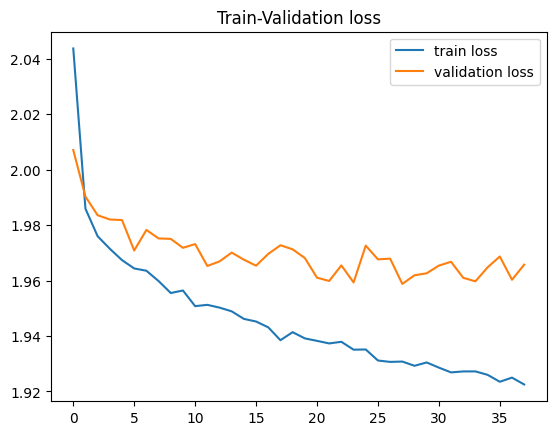

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_relative_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6616161616161617, 'precision': 0.6616161616161617, 'f1': 0.6616161616161617, 'accuracy': 0.6616161616161617}, 'as': {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}, 'about': {'recall': 0.8176020408163265, 'precision': 0.8176020408163265, 'f1': 0.8176020408163265, 'accuracy': 0.8176020408163265}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}, 'as': {'recall': 0.7045454545454546, 'precision': 0.7045454545454546, 'f1': 0.7045454545454546, 'accuracy': 0.7045454545454546}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6141732283464567, 'precision': 0.6141732283464567, 'f1': 0.6141732283464567, 'accuracy': 0.6141732283464567}, 'a

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0497228229087403 	 Validation loss: 2.004827131659298 	 
  1%|          | 574/57400 [02:24<3:12:01,  4.93it/s]
Epoch 2 	 Training loss: 1.9919504180602496 	 Validation loss: 1.9878936965586775 	 
  2%|▏         | 1148/57400 [04:48<4:03:23,  3.85it/s]
Epoch 3 	 Training loss: 1.9795050321971082 	 Validation loss: 1.9867200023036893 	 
  3%|▎         | 1722/57400 [07:12<3:42:19,  4.17it/s]
Epoch 4 	 Training loss: 1.9711408671186361 	 Validation loss: 1.9873042268268133 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:36<3:40:40,  4.16it/s]
Epoch 5 	 Training loss: 1.9681802230014203 	 Validation loss: 1.9769736669831357 	 
  5%|▌         | 2870/57400 [12:00<3:40:30,  4.12it/s]
Epoch 6 	 Training loss: 1.9675721266543824 	 Validation loss: 1.977502065189814 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:24<3:37:15,  4.14it/s]
Epoch 7 	 Training loss: 1.9619657945549862 	 Validation loss: 1.9890982559171773 	 

2 epoch without imp

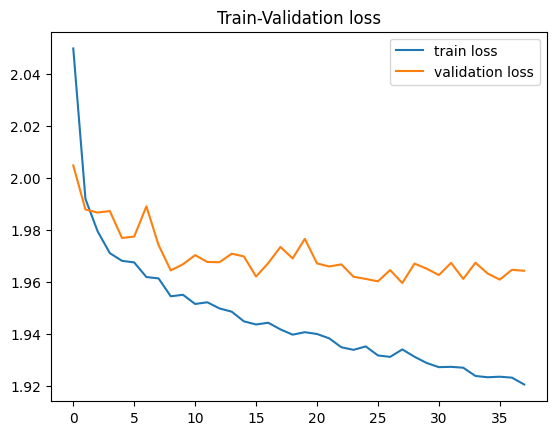

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_relative_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6654040404040404, 'precision': 0.6654040404040404, 'f1': 0.6654040404040404, 'accuracy': 0.6654040404040404}, 'as': {'recall': 0.7170795306388527, 'precision': 0.7170795306388527, 'f1': 0.7170795306388528, 'accuracy': 0.7170795306388527}, 'about': {'recall': 0.8150510204081632, 'precision': 0.8150510204081632, 'f1': 0.8150510204081632, 'accuracy': 0.8150510204081632}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}, 'as': {'recall': 0.7121212121212122, 'precision': 0.7121212121212122, 'f1': 0.7121212121212122, 'accuracy': 0.7121212121212122}, 'about': {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6220472440944882, 'precision': 0.6220472440944882, 'f1': 0.6220472440944882, 'accuracy': 0.6220472440944882}, 'a

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0488126780513274 	 Validation loss: 2.009504591004323 	 
  1%|          | 574/57400 [03:55<5:00:14,  3.15it/s]
Epoch 2 	 Training loss: 1.9959723469687671 	 Validation loss: 1.9977201930547164 	 
  2%|▏         | 1148/57400 [07:51<4:51:28,  3.22it/s]
Epoch 3 	 Training loss: 1.9807251104079058 	 Validation loss: 1.9924322972863406 	 
  3%|▎         | 1722/57400 [11:21<4:05:19,  3.78it/s]
Epoch 4 	 Training loss: 1.9736283585584953 	 Validation loss: 1.9821277351702673 	 
  4%|▍         | 2296/57400 [14:41<4:48:01,  3.19it/s]
Epoch 5 	 Training loss: 1.971422458774952 	 Validation loss: 1.9884788909200894 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [18:38<5:06:06,  2.97it/s]
Epoch 6 	 Training loss: 1.9665316536451467 	 Validation loss: 1.9768451714919786 	 
  6%|▌         | 3444/57400 [21:52<4:57:12,  3.03it/s]
Epoch 7 	 Training loss: 1.962932446900145 	 Validation loss: 1.9743972834894212 	 
  7%|▋         | 4018/57400 [25:19<4:57:26,  2.99i

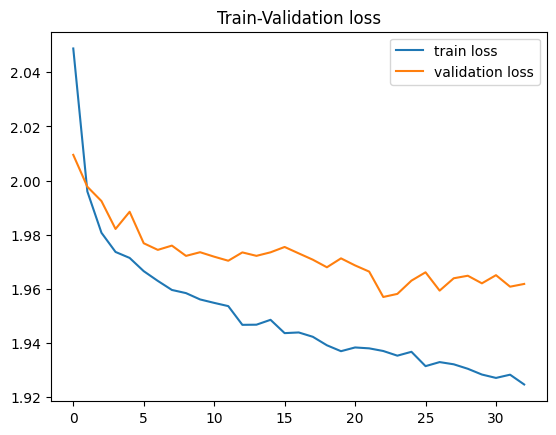

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_relative_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6628787878787878, 'precision': 0.6628787878787878, 'f1': 0.6628787878787878, 'accuracy': 0.6628787878787878}, 'as': {'recall': 0.7209908735332464, 'precision': 0.7209908735332464, 'f1': 0.7209908735332464, 'accuracy': 0.7209908735332464}, 'about': {'recall': 0.8303571428571429, 'precision': 0.8303571428571429, 'f1': 0.8303571428571429, 'accuracy': 0.8303571428571429}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6982968369829684, 'precision': 0.6982968369829684, 'f1': 0.6982968369829684, 'accuracy': 0.6982968369829684}, 'as': {'recall': 0.6994949494949495, 'precision': 0.6994949494949495, 'f1': 0.6994949494949495, 'accuracy': 0.6994949494949495}, 'about': {'recall': 0.8463541666666666, 'precision': 0.8463541666666666, 'f1': 0.8463541666666666, 'accuracy': 0.8463541666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6246719160104987, 'precision': 0.6246719160104987, 'f1': 0.6246719160104987, 'accuracy': 0.6246719160104987}, 'a

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8210034013605442, 'precision': 0.8210034013605442, 'f1': 0.8210034013605442, 'accuracy': 0.8210034013605442}
Métricas etiqueta male: {'recall': 0.8428819444444444, 'precision': 0.8428819444444444, 'f1': 0.8428819444444444, 'accuracy': 0.8428819444444444}
Métricas etiqueta female:  {'recall': 0.7999999999999999, 'precision': 0.7999999999999999, 'f1': 0.7999999999999999, 'accuracy': 0.7999999999999999}

 to
Resultado global: {'recall': 0.6632996632996633, 'precision': 0.6632996632996633, 'f1': 0.6632996632996633, 'accuracy': 0.6632996632996633}
Métricas etiqueta male: {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}
Métricas etiqueta female:  {'recall': 0.6202974628171478, 'precision': 0.6202974628171478, 'f1': 0.6202974628171478, 'accuracy': 0.6202974628171478}

 as
Resultado global: {'recall': 0.7188179052585832, 'precision': 0.7188179052585832, 'f1': 0.7